# Old School RuneScape Time-To-Kill Calculations

In [1364]:
import functools
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import random
from IPython.display import clear_output

pd.set_option('display.max_rows', None)

As an OSRS rule of thumb, we want to pick the armour and weapon configuration that deals the highest damage per second (DPS) against our enemies. However, there are certain factors which lead to situations in which more complex strategies than the standard click-and-wait approach shine:

- We might not care about the delay of the weapon used for the last hit, since we only care about single-kill times or we might need to wait for more enemies to spawn. In these cases, using a higher-hitting but lower-DPS weapon for the last hit might be a good strategy.
- If we use a slow weapon for the last hit and we want to move on to another enemy afterwards, DPS may be lost since the damage output is capped to be no more than the remaining health of the enemy. In such cases, we might want to change to a faster weapon to be able to transition to a new enemy quicker.
- We might want to optimize for potential, not average performance. This might be the case when speedrunning bosses with shorter fight durations, for example.

Loosely, damage in OSRS is calculated using a two-step process. The first step is the accuracy roll: we sample from a Bernoulli distribution with parameter $p$. If the value is 0, the attack misses and the damage is 0. If the roll is successfull, the damage is sampled from $U[0, d_\textrm{max}]$, where $d_\textrm{max}$ is the max hit of the weapon. Thus, there are two different ways of rolling a zero: missing the accuracy roll, or passing the accuracy roll and then rolling a zero on damage.

We implement a class describing the damage distribution of most standard weapons bearing this in mind:

In [1365]:
class SingleHit:
    def __init__(self, prob_hit: float, max_hit: int):
        self.prob_hit = prob_hit
        self.max_hit = max_hit
    
    def support(self):
        return range(0, self.max_hit + 1)

    def sample(self):
        if random.random() <= (1 - self.prob_hit):
            return 0

        return random.randint(0, self.max_hit)

    def prob(self, damage):
        if not 0 <= damage <= self.max_hit:
            return 0

        p_hit = self.prob_hit / (self.max_hit + 1)

        # Two ways of rolling a zero: fail accuracy roll or pass accuracy roll and roll a 0.
        if damage == 0:
            return (1 - self.prob_hit) + p_hit

        return p_hit

The scythe is an interesting weapon for which damage is calculated slightly differently. Here, the single-hitsplat logic is repeated three times. The three hitsplats share the same accuracy but have different max values. One hit is at full power, one at half of that and one at 0.25 times the full power, rounded down. The hits are independent. Using this we can compute the distribution for the total damage done by a scythe swing as a repeated convolution.

We implement a class describing the distribution of a convolution of $n$ distributions:

In [1366]:
class Convolution:
    def __init__(self, u, v):
        self.u = u
        self.v = v
 
    def support(self):
        return range(self.u.support()[0] + self.v.support()[0], self.u.support()[-1] + self.v.support()[-1] + 1)

    def sample(self):
        return self.u.sample() + self.v.sample()

    @functools.lru_cache(maxsize=None)
    def prob(self, x: int):
        return sum([self.u.prob(i) * self.v.prob(x - i) for i in self.u.support()])

    @staticmethod
    def convolve_all(*distributions):
        assert len(distributions) >= 2

        convolved = distributions[0]

        for distribution in distributions[1:]:
            convolved = Convolution(convolved, distribution)
            
        return convolved

We now move on to defining parameters for the toxic blowpipe and the scythe which will be used for example calculations, using fairly standard inferno speedrunning setups. We use a ranger (Jal-Xil) as a target because they seem to have some of the most wonky strategies among the inferno mobs.

Values can be copied from the excellent fruitdeeps calculator.

In [1367]:
MOB_HEALTH = 130

SCYTHE_ACC = 0.9398
SCYTHE_MAX = 51

PIPE_ACC = 0.9461
PIPE_MAX = 35

scythe = Convolution.convolve_all(
    SingleHit(SCYTHE_ACC, SCYTHE_MAX),
    SingleHit(SCYTHE_ACC, int(0.5 * SCYTHE_MAX)),
    SingleHit(SCYTHE_ACC, int(0.25 * SCYTHE_MAX)),
)

pipe = SingleHit(PIPE_ACC, PIPE_MAX)

weapons = { 'pipe': (pipe, 2), 'scythe': (scythe, 5) }

The time to kill (TTK) satisfies the recursive equation
$$\textrm{ttk}[x] = \mathbb{E}\left[ c(D) + \textrm{ttk}[\max(x - D, 0)] \right]$$
where
$$c(d) = \begin{cases} 
    0 & \textrm{if } x - h \leq 0 \\
    t & \textrm{otherwise.}
\end{cases}$$

We use this cost definition for last-hit strategies to emerge. The cooldown duration after the last mob is killed is assumed to be irrelevant because we will be waiting for the next wave anyway. The calculation ignores factors such as animation delay and other kinds of obscure engine vodoo, but this can easily be added into the cost definition.

Implementing this directly using recursive dynamic programming is problematic because we can transition back to the current problem in the case where we hit a zero, leading to an infinite recursion. We can work around this by expanding the expectation and rearranging as
$$\textrm{ttk}[x] = P(D = 0) \textrm{ttk}[x] + \sum_{d=1}^{d_\textrm{max}} P(D = d) c(x - d) $$
Here, as long as $0 \leq P(H = 0) < 1$, in each state we have an $P(H = 0)$-contraction in $\mathbb{R}$. We can use this formula as an iterative update rule or solve it directly. To solve it directly, we see that $x = \alpha x + c \Rightarrow x = \frac{c}{1-\alpha}$. Thus, we can compute the sum and then handle the self-recurrence by adding a correction term.

In [1368]:
time_to_kill = [math.inf for i in range(MOB_HEALTH + 1)]
best_weapon = [None for i in range(MOB_HEALTH + 1)]

time_to_kill[0] = 0

for hp in range(1, MOB_HEALTH + 1):
    for name, (dist, delay) in weapons.items():
        value = 0

        for hit in dist.support()[1:]:
            value += dist.prob(hit) * ((delay if hp - hit > 0 else 0) + time_to_kill[max(hp - hit, 0)])

        value = (value + delay * dist.prob(0)) / (1 - dist.prob(0))

        if value < time_to_kill[hp]:
            time_to_kill[hp] = value
            best_weapon[hp] = name

pd.DataFrame(zip(range(1, MOB_HEALTH + 1), best_weapon[1:], time_to_kill[1:]), columns=['HP', 'Weapon', 'TTK'])

,HP,Weapon,TTK
0,1,scythe,0.005001
1,2,scythe,0.010766
2,3,scythe,0.018627
3,4,scythe,0.028825
4,5,scythe,0.041603
5,6,scythe,0.057205
6,7,scythe,0.075878
7,8,scythe,0.097870
8,9,scythe,0.123432
9,10,scythe,0.152817


We see that the time to kill using optimal switching is approximately 13.49 ticks and that the strategy consists of piping first and then scything. Other armour leads to strategies such as scything, piping, then scything again.

This is the average time-to-kill. The underlying distribution is called a phase-type distribution. There are closed formulas for probabilities expressed using matrix multiplications, but those are costly to compute. In our case, we have a very structured problem where there are self-loops but no loops back to a higher hitpoint, which allows us to continue with simple dynamic programming: we have a similar recurrence for the probability of the TTK being a certain value by marginalizing over hits. When there are 0 ticks left, the probability is the probability that we kill the monster in one hit. For other values, we have the recursive equation

$$
    P[\textrm{TTK} = t \, | \, \textrm{HP} = h] = \sum_{d} P(D = h \, | \, HP = h) [P(\textrm{TTK} = t - \textrm{delay} \, | \, \textrm{HP} = h - H)].
$$

Here, delay refers to the delay of the weapon that the policy dictates should be used at the current opponent hitpoint level, and the expectation is again over damage dealt by the player. 

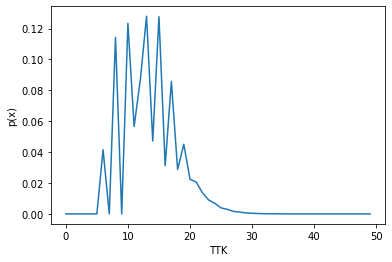

In [1369]:
@functools.lru_cache(maxsize=None)
def p(ttk, hp):
    if hp <= 0:
        return 0

    if ttk < 0:
        return 0

    dist, delay = weapons[best_weapon[hp]]

    if ttk == 0:
        return sum(dist.prob(hit) if hp - hit <= 0 else 0 for hit in dist.support())

    return sum(dist.prob(hit) * p(ttk - delay, hp - hit) for hit in dist.support())

n_bins = 50

x_values = range(n_bins)
y_values = [p(x, MOB_HEALTH) for x in x_values]

plt.xlabel('TTK')
plt.ylabel('p(x)')
plt.plot(x_values, y_values)

We can verify that the probabilities are correct by using them to compute the mean again:

In [1370]:
print(np.dot(x_values, y_values))

13.486017704037188


Another interesting problem is to consider other optimization problems than average time-to-kill. For example, we might want to maximize our chance of breaking the world-record speedrun of some boss using intricate weapon selections.

We can solve this using dynamic programming by giving a reward of 1 for breaking the target and 0 otherwise. Solving this MDP using dynamic programming yields a policy which maximizes the expected reward, i.e. maximizing the probability of making the cutoff.

Note that in this case we need a non-stationary policy - one that depends on the amount of time the agent has left to make the cutoff.

In [1371]:
target_ticks = 10

reward = [[0 for j in range(target_ticks + 1)] for i in range(MOB_HEALTH + 1)]
best_weapon = [[None for j in range(target_ticks + 1)] for i in range(MOB_HEALTH + 1)]

for hp in range(1, MOB_HEALTH + 1):
    for remaining_ticks in range(target_ticks + 1):
        for name, (dist, delay) in weapons.items():
            value = 0

            for hit in dist.support():
                if hp - hit <= 0:
                    r = 1
                elif remaining_ticks - delay < 0:
                    r = 0
                else:
                    r = reward[hp - hit][remaining_ticks - delay]

                value += dist.prob(hit) * r

            if value > reward[hp][remaining_ticks]:
                reward[hp][remaining_ticks] = value
                best_weapon[hp][remaining_ticks] = name

pd.DataFrame(best_weapon)

,0,1,2,3,4,5,6,7,8,9,10
0,None,None,None,None,None,None,None,None,None,None,None
1,scythe,scythe,pipe,pipe,pipe,scythe,pipe,scythe,pipe,scythe,scythe
2,scythe,scythe,pipe,pipe,pipe,scythe,pipe,scythe,pipe,scythe,scythe
3,scythe,scythe,pipe,pipe,pipe,scythe,pipe,scythe,pipe,scythe,scythe
4,scythe,scythe,pipe,pipe,pipe,scythe,pipe,scythe,pipe,scythe,scythe
5,scythe,scythe,pipe,pipe,pipe,scythe,pipe,scythe,pipe,scythe,scythe
6,scythe,scythe,pipe,pipe,pipe,scythe,pipe,scythe,pipe,scythe,scythe
7,scythe,scythe,pipe,pipe,pipe,scythe,pipe,scythe,pipe,scythe,scythe
8,scythe,scythe,pipe,pipe,pipe,scythe,pipe,scythe,pipe,scythe,scythe
9,scythe,scythe,pipe,pipe,pipe,scythe,pipe,scythe,pipe,scythe,scythe


Computing the TTK distribution is more difficult here becaue the policy now depends on time. If we try to apply the previous TTK probability recursion here, we end up with probabilities that fail to sum to 1. That is, using the recursion

$$
    P(\textrm{TTK} = t \, | \, \textrm{HP} = h) = \sum_{d} P(D = h \, | \, \textrm{HP} = h, \textrm{TTK} = t) P(\textrm{TTK} = t - \textrm{delay} \, | \, \textrm{HP} = h - H)
$$

fails. This is because the distribution of $D$ now also depends on $TTK$. For clarity, we could write this as 

$$
P(\textrm{TTK} = t \, | \, \textrm{HP} = h, \textrm{TicksRemaining} = t) = \sum_{d} P(D = h \, | \, \textrm{HP} = h, \textrm{TicksRemaining} = t) P(\textrm{TTK} = t - \textrm{delay} \, | \, \textrm{HP} = h - H), \textrm{TicksRemaining} = t - \textrm{delay} .
$$

We cannot expect $P(\textrm{TTK} = a \, | \, \textrm{HP} = h, \textrm{TicksRemaining} = a)$ and $P(\textrm{TTK} = b \, | \, \textrm{HP} = h, \textrm{TicksRemaining} = b)$ to sum to 1 for $a \neq b$, since they belong to different distributions.

To progress, we can evaluate this policy using a Monte Carlo simulation:

14.151473


(array([4.41621622e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.39255405e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00810811e-03, 2.60963514e-01, 2.85918919e-02, 0.00000000e+00,
        1.98170270e-01, 0.00000000e+00, 1.23814865e-01, 0.00000000e+00,
        0.00000000e+00, 1.33054054e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.34324324e-02, 2.70270270e-06, 0.00000000e+00, 5.53918919e-03,
        5.40540541e-06, 2.10540541e-03, 0.00000000e+00, 8.10810811e-06,
        8.37837838e-04, 8.10810811e-06, 0.00000000e+00, 2.78378378e-04,
        0.00000000e+00, 7.83783784e-05, 0.00000000e+00, 2.70270270e-06,
        2.56756757e-05, 1.35135135e-06, 0.00000000e+00, 2.70270270e-06,
        0.00000000e+00, 2.70270270e-06]),
 array([ 5.  ,  5.74,  6.48,  7.22,  7.96,  8.7 ,  9.44, 10.18, 10.92,
        11.66, 12.4 , 1

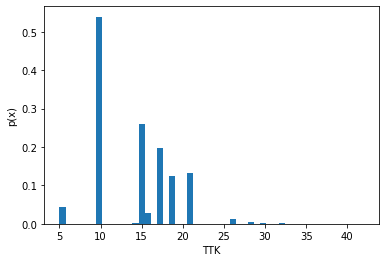

In [1372]:
data = []

for i in range(int(1e6)):
    hp = MOB_HEALTH

    ttk = 0

    while hp > 0:
        try:
            weapon = best_weapon[hp][target_ticks - ttk]
        except:
            weapon = None

        weapon = weapon or 'pipe'

        dist, delay = weapons[weapon]

        hp = hp - dist.sample()

        if hp <= 0:
            break
            
        ttk += delay

    data.append(ttk)

print(np.mean(data))

plt.xlabel('TTK')
plt.ylabel('p(x)')
plt.hist(data, density=True, bins=n_bins)